In [6]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
from tqdm import tqdm
from dateutil import tz
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
#!pip install redis
import redis
redis_ip = '34.211.59.66'
r = redis.StrictRedis(redis_ip)
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

In [7]:
import psycopg2 as pg2
import psycopg2.extras as pgex
this_host='34.211.59.66'
this_user='postgres'
this_password='postgres'
conn = pg2.connect(host = this_host, 
                        user = this_user,
                        password = this_password)

sql_select = '''select created_at, location, tweet_content, cleaned_tweet, hashtags, date, time, date_time  
                from tweets where (date_time >= NOW() - '18 hour'::INTERVAL) and hashtags is not null and hashtags != 'None';'''

cur = conn.cursor(cursor_factory=pgex.RealDictCursor)
cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)
df.reset_index(inplace = True)
df['created_datetime'] = pd.to_datetime(df['created_at'])
df['year'] = df.created_datetime.apply(lambda x: x.year)
df['month'] = df.created_datetime.apply(lambda x: x.month)
df['day'] = df.created_datetime.apply(lambda x: x.day)
df['hour'] = df.created_datetime.apply(lambda x: x.hour)
len(df)

17340

In [8]:
df = df[~df['hashtags'].str.contains('amp')]
df = df[~df['hashtags'].str.contains('job|hiring|sales|retail|clerical')]
df = df[~df['hashtags'].str.contains('dallas|plano|irving|richardson|garland|allen|odessa|midland|sanfrancisco|losangeles|irvine|garland')]

In [9]:
len(df)

12193

In [10]:
df[~df['location'].str.contains('.ca|california')][~df['location'].str.contains('.tx|texas')]

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


index                                      cleaned_tweet  \
34        34  1991 pens won cup in minn 1992 pens won cup in...   
146      146  interview with . rod fergusson for #xboxallfor...   
184      184  . demonstrating the portability of the #xboxon...   
195      195  leaving #sfo it's easy to see how uber and lyf...   
216      216  bought a fan for the summer #venicebeach #gyps...   
236      236  "shut that crap off!" there is no one like the...   
238      238  so much fun #icecreammuseum #sparksnthecity #i...   
244      244  meeting . one on the biggest highlights of my ...   
252      252  monday is my first day at and i'm having a tou...   
271      271  the staff who work at on sunset boulevard duri...   
273      273  goal, #usmnt! michael bradley chips ochoa from...   
275      275  it's mr.fanfest himself . great to meet you! #...   
298      298  #fuel and #alreadygone i stopped in amarillo f...   
309      309  my day is complete. #disneyland #starwars #sun...   
323      323  lmao i had to look to see if it was the #polic...   
349      349   x #blackpanther #teaser #trailer #reaction #a...   
364      364  #spiritintheroom headlines our collective birt...   
399      399  america misses the obama administration so muc...   
402      402  another #playboyjazzfestival as the annual tra...   
419      419  biggest #xbox fan i know and all around great ...   
456      456  over an hour sitting on the runway waiting for...   
458      458  make ya' next move ya' best move. #houston #ch...   
466      466          has dethroned reigning champ #puncontest    
484      484  daily before apple store opens #dailymeeting #...   
492      492  #mercedesbenz #blackout polish time lapse 2. f...   
540      540  mefuckingpro-hacksfuckingamateurhour mecanfixa...   
561      561  walking around in underwear when no one is hom...   
567      567              the fairest queen of them all #pride    
615      615  first you get that money then you get that pow...   
636      636  hangin' out with my very good friend (#trinite...   
...      ...                                                ...   
16598  16598   i tried to retweet this but it’s against twit...   
16624  16624    a bunch of balls at the booth at . #e3 #e32017    
16639  16639  #fathersday is less than a week away! don't wo...   
16672  16672  german pr is ready for the press conference. #...   
16723  16723  just ran into abc7 news pa getting her nails d...   
16725  16725               the ubisoft e3 hype is real  #ubie3    
16737  16737             haha he's still going. #spacebrothers    
16768  16768                     what can show us at #e32017 ?    
16800  16800               the ubisoft e3 hype is real  #ubie3    
16815  16815                              #ubie3 w/ the squad     
16828  16828  ✨better late than never ✨ i'm so grateful for ...   
16846  16846  this is #2 off-duty border patrol agent found ...   
16889  16889  moments away from #ubie3! i've had a sneak pee...   
16929  16929  words cannot express how grateful we are 4 our...   
16933  16933                 burning off monday #fitness #goals   
16969  16969  album coming soon... jk! yesterday's lookbook1...   
16980  16980  . funniest sequence of photos ever while i jus...   
16988  16988                       sony e3! here we go! #e32017   
16999  16999  new on our #dessert menu is the chocolate bakl...   
17021  17021  recap from our graduations! congrats to our ki...   
17049  17049  “relax” rt “stop acting dramatic.” rt #wordsth...   
17092  17092  students and parents ready to #leadtogether at...   
17119  17119  just saw this posted at t3. a post-security co...   
17151  17151  hike a bike  #bikepacking #mtb #mountainbiking...   
17188  17188  super fun interview with . . for #xboxallforon...   
17191  17191  mixing with caveman workshop. the cave-malibu....   
17193  17193  #pulsenightclub  #orlandounitedday  #pridemont...   
17196  17196  rather than airing the 2017 #mlbdraft, s

In [11]:
ca_df = df[df['location'].str.contains('.ca|california')]
tx_df = df[df['location'].str.contains('.tx|texas')]

In [12]:
def word_cloud(state = None): 
    state = state.lower()
    state_df = df[df['location'].str.contains('.{}'.format(state))]
    words = state_df['hashtags'][(state_df['hashtags'].isnull() == False) & (state_df['hashtags'] != 'None')]
    stopwords = set(STOPWORDS)
    #stopwords.add("amp")
    wc = WordCloud(width=1600, height=800, background_color='white', \
                   relative_scaling=1, stopwords=stopwords, colormap='copper').generate(' '.join(i for i in words))
    plt.figure(figsize=(20,10))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    return

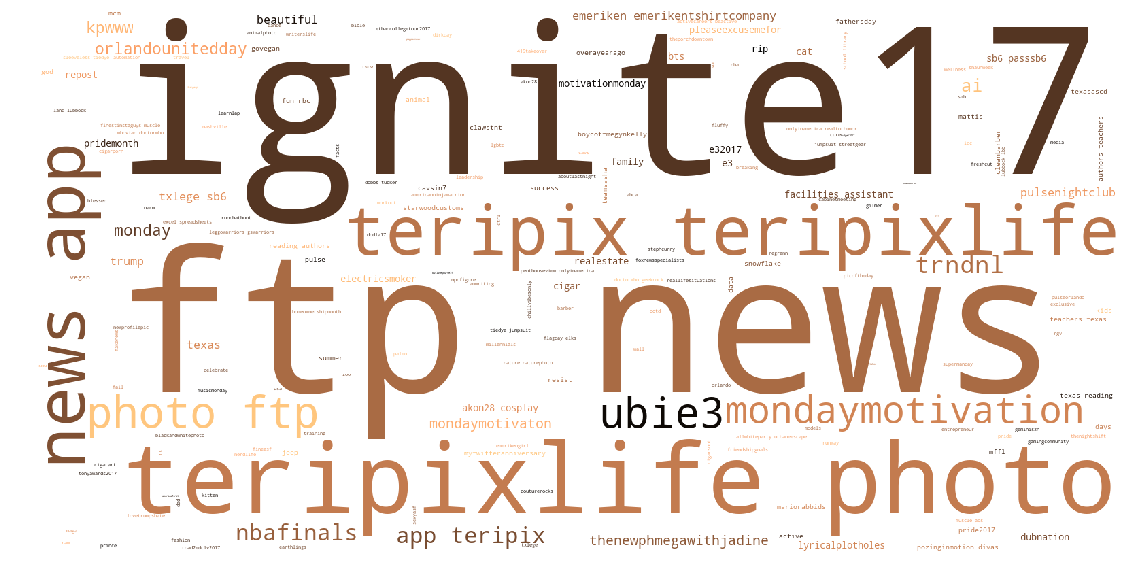

In [13]:
word_cloud('TX')

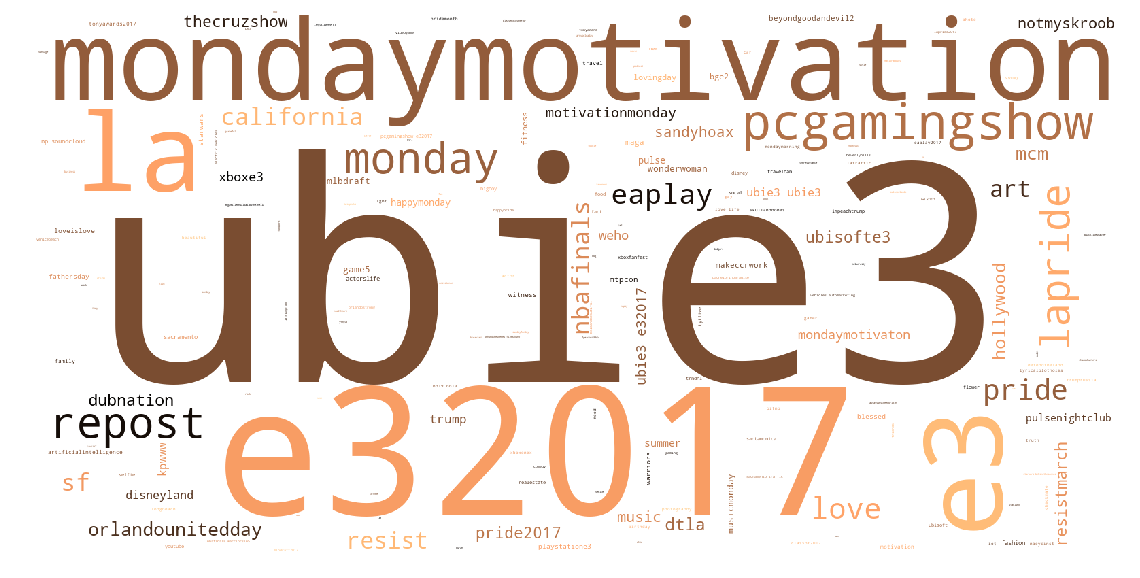

In [14]:
word_cloud('CA')

In [15]:
hastages_series = df['hashtags']
len(hastages_series)

12193

In [16]:
count_vectorizer = CountVectorizer(min_df = 1, stop_words='english')
hashtags_countvec = count_vectorizer.fit_transform(hastages_series)
#hashtags_countvec = pickle.dumps(hashtags_countvec_fit)
#r.set('hashtags_countvec_fit_temp', hashtags_countvec)
#hashtags_countvec = pickle.loads(r.get('hashtags_countvec_fit_temp'))

In [17]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = .25)
time_gap = timedelta(hours = 0.1)
windows = int(round(time_delta/time_gap,0))
print('start time: ', min(df['created_datetime']),'\n',\
      'end time:  ', max(df['created_datetime']),'\n',\
      'total hours: ',time_window,'\n',\
      'time lag: ', time_lag,'\n',\
      'time gap: ', time_gap,'\n',\
      'time windows: ', windows)

start time:  2017-06-12 06:17:11 
 end time:   2017-06-13 00:17:00 
 total hours:  17 
 time lag:  0:15:00 
 time gap:  0:06:00 
 time windows:  180


In [18]:
def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    
    return result

In [74]:
def new_trend_period(trend_group):        
    new_result = []
    count = 0
    for i in range(len(trend_group)-1):
        if (count > len(trend_group)-2):
            pass
        else:
            gap = ((trend_group[count+1][0]) - (trend_group[count][len(trend_group[count])-1]))
            if gap <.8*min((trend_group[count+1][0]), (trend_group[count][len(trend_group[count])-1])):
                new_period = trend_group[count]+trend_group[count+1]
                new_result.append(new_period)
                count +=2
            else:
                new_result.append(trend_group[count])
                count +=1
    return new_result

In [129]:
new_result = []
count = 1
for i in range(len(result)-1):
    print((result[i+1][0]) - (result[i][len(result[i])-1]))

2
14
4


In [141]:
new_result = []
count = 0
for i in range(len(result)-1):
    print(len(result)-1)
    if (count > len(result)-2):
        pass
    else:
        gap = ((result[count+1][0]) - (result[count][len(result[count])-1]))
        if gap <3:
            new_result.append(result[count]+result[count+1])
            count +=2
        else:
            new_result.append(result[count])
            count +=1

3
3
3


In [142]:
new_result

[[1, 2, 3, 4, 5, 7, 8], [22, 23, 24, 25]]

In [77]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = .3)
time_gap = timedelta(hours = .1)
windows = int(round(time_delta/time_gap,0))
time_format = '%Y-%h-%d %a %I %p'
from_zone = tz.tzutc()
#to_zone = tz.tzlocal()
to_zone = 'US/Pacific'
def hashtag_trend(hashtag):
    hashtag = hashtag.lower()
    arr = []
    arr_all = []
    start_time = min(df['created_datetime'])
    for window in range(windows):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) & (df['created_datetime'] > start_time))]
        h = subset.str.contains(hashtag).mean()
        arr.append(h)
        #arr_all.append(subset.mean())
        start_time += time_gap
    w = np.array(range(windows))
    timeline = []
    for i in w:
        timeline.append(min(df['created_datetime']) + time_gap * i) 
    arr = np.array(arr)  
    #arr_all = np.array(arr_all) 
    grad = np.gradient(arr)
    #grad2 = np.gradient(grad)
    #tr = np.argwhere(grad>.01).reshape(1,-1)[0]
    time_df = pd.DataFrame({'arr':arr,'grad':grad},index=timeline)
    rolmean_arr = pd.rolling_mean(arr, window=12)
    rolstd_arr = pd.rolling_std(arr, window=12)
    rolmean_grad = np.gradient(rolmean_arr)
    spike = []
    trend = np.argwhere(rolmean_grad>0.001).reshape(1,-1)[0]
    trend_group = group_consecutives(trend)
        
    trend_group1 = new_trend_period(trend_group)
    #if trend_group1 != trend_group:
    #    trend_group1 = new_trend_period(trend_group1)
        
    trend_group2 = [i for i in trend_group1 if (len(i) > 7)]
    spike.append([[i[0],i[len(i)-1]] for i in trend_group2])
    spike = np.array(spike)
    spk1 = [i[0] for i in spike[0]]
    spk2 = [i[1] for i in spike[0]]
        
    plt.figure(figsize=(14,7))
    plt.plot(arr, label='Hashtag Frequency',c = 'navy')
    plt.plot(rolmean_arr, label='Rolling Means',c = 'lightblue')
    plt.plot(rolstd_arr, label='Rolling STDs',c = 'gray')
    plt.plot(rolmean_grad, label='Gradient over Rolling Means',c = 'red')
    #plt.plot(grad2, label='grad2 Slope')
    for j,k in zip(spk1,spk2):
        spike1 = (min(df['created_datetime']) + time_gap * j) 
        spike1 = spike1.replace(tzinfo=from_zone)
        spike1_et = spike1.astimezone(to_zone)
        spike1_et = spike1_et.strftime(time_format)
       
        spike2 = (min(df['created_datetime']) + time_gap * k) 
        spike2 = spike2.replace(tzinfo=from_zone)
        spike2_et = spike2.astimezone(to_zone)
        spike2_et = spike2_et.strftime(time_format)           
        plt.axvline(j, color = 'salmon',linestyle='dashed', label = 'Trending: {}'.format(spike1_et))
        plt.axvspan(j, k, alpha=0.2, color='lightcoral')
    plt.title(hashtag, fontsize=20)    
    plt.legend(fontsize=12) 
    ### -----ARIMA MODELING
#     from statsmodels.tsa.arima_model import ARIMA
#     w = np.array(range(windows))
#     timeline = []
#     for i in w:
#         timeline.append(min(df['created_datetime']) + time_gap * i) 
#     arima_df = pd.DataFrame({'perf':arr},index=timeline)   

#     series = arima_df
#     model = ARIMA(series, order=(5,1,0))
#     model_fit = model.fit()
#     print(model_fit.summary())
#     # plot residual errors
#     residuals =pd. DataFrame(model_fit.resid)
#     residuals.plot()
#     plt.show()
#     residuals.plot(kind='kde')
#     plt.show()
#     print(residuals.describe())
    ###-----------------
    return  time_df

In [52]:
hashtag_freq_df = pd.DataFrame({'hashtag': count_vectorizer.get_feature_names(), 'occurrences':np.asarray(hashtags_countvec.sum(axis=0)).ravel().tolist()})
hashtag_freq_df['frequency'] = hashtag_freq_df['occurrences']/np.sum(hashtag_freq_df['occurrences'])
hashtag_freq_df.sort_values(by = 'occurrences',ascending = False, inplace = True)

In [53]:
hashtag_freq_df.head(10)

hashtag  occurrences  frequency
11744             ubie3          347   0.013896
3263             e32017          281   0.011253
8000         nowplaying          195   0.007809
2564          cubevenue          190   0.007609
7319   mondaymotivation          158   0.006327
3260                 e3          145   0.005807
6107                 la          120   0.004806
8394       pcgamingshow          115   0.004605
9250             repost          103   0.004125
3290         earthquake          100   0.004005

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:33: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:34: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater


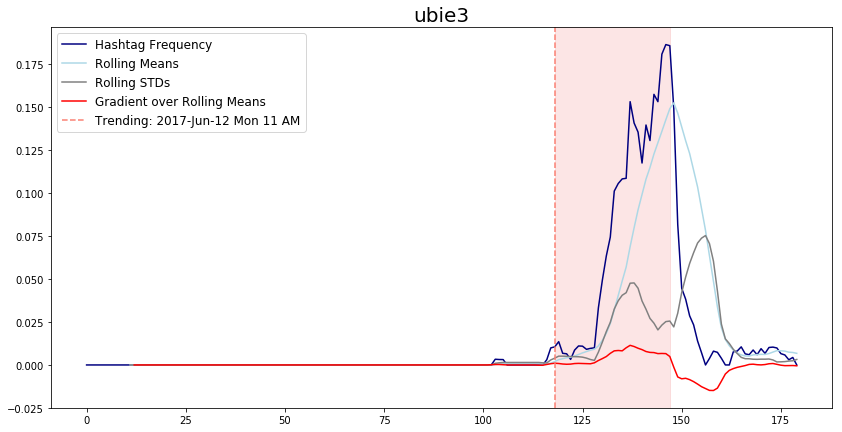

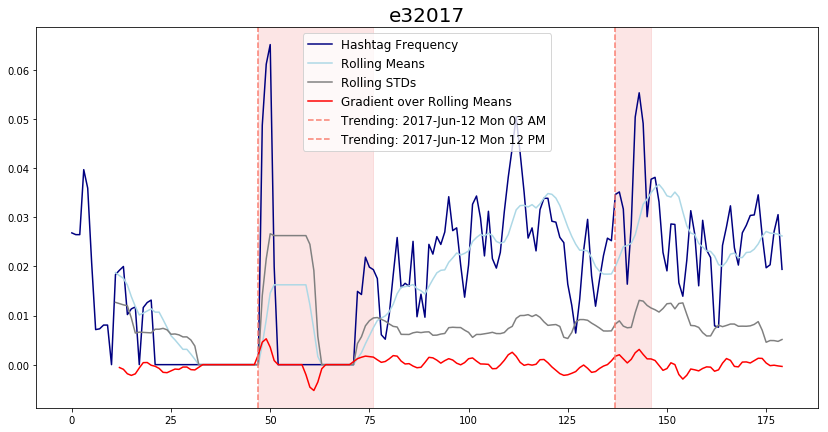

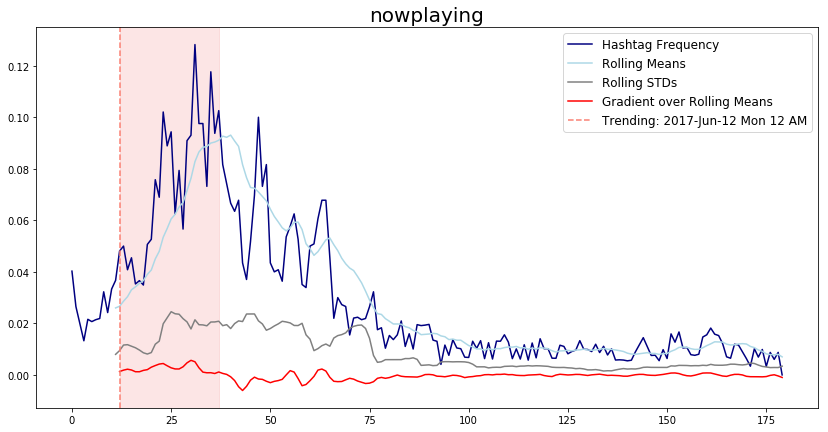

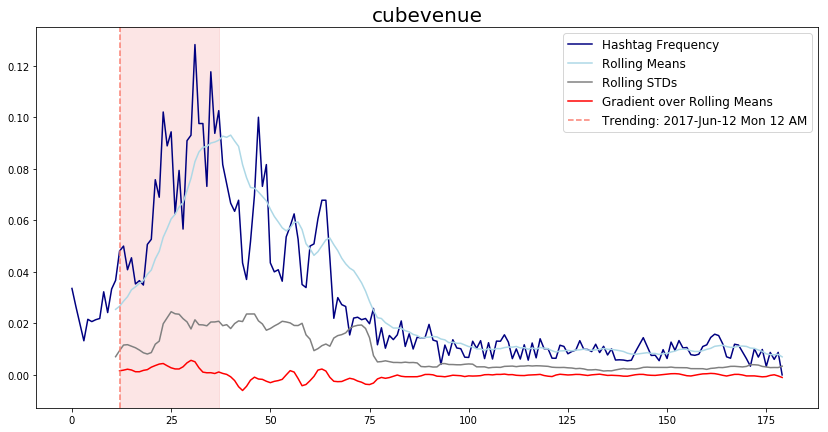

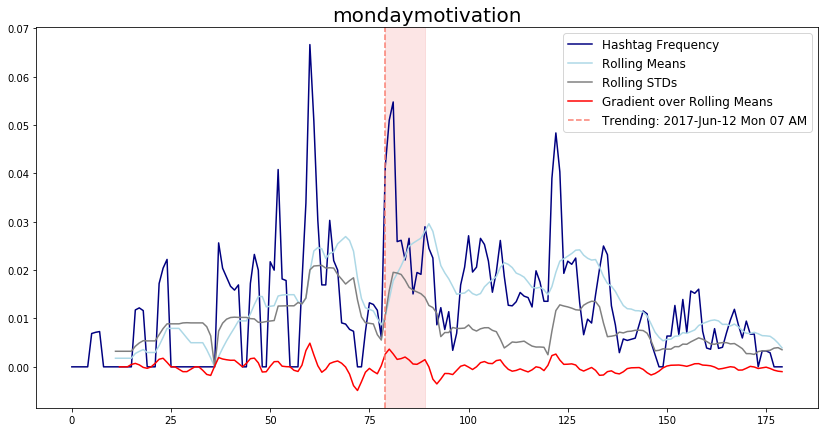

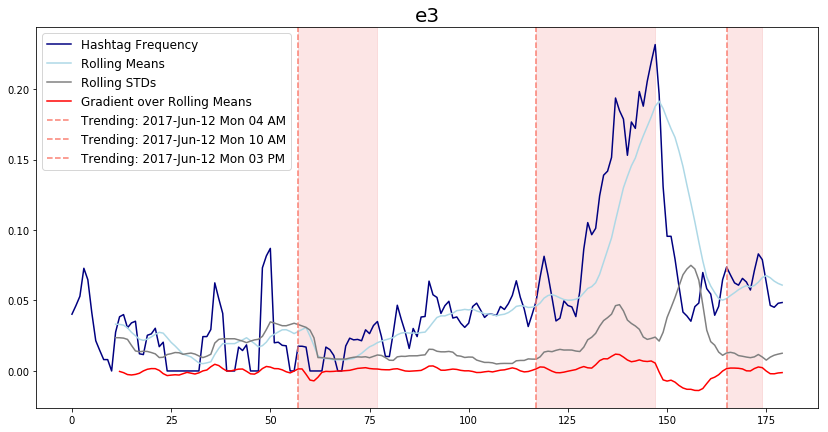

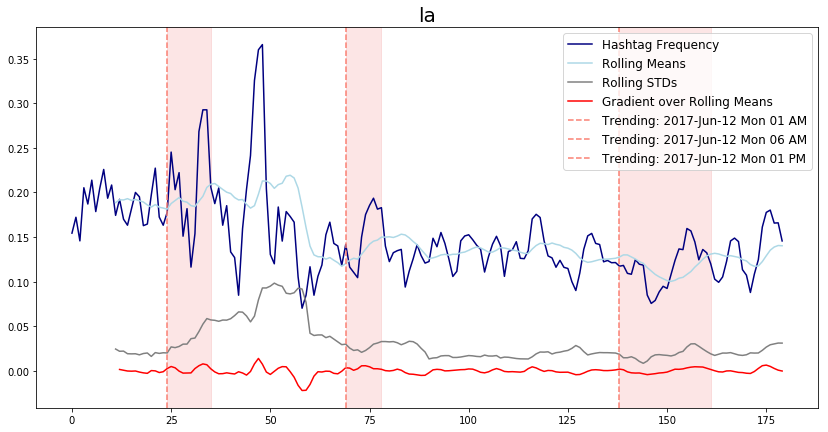

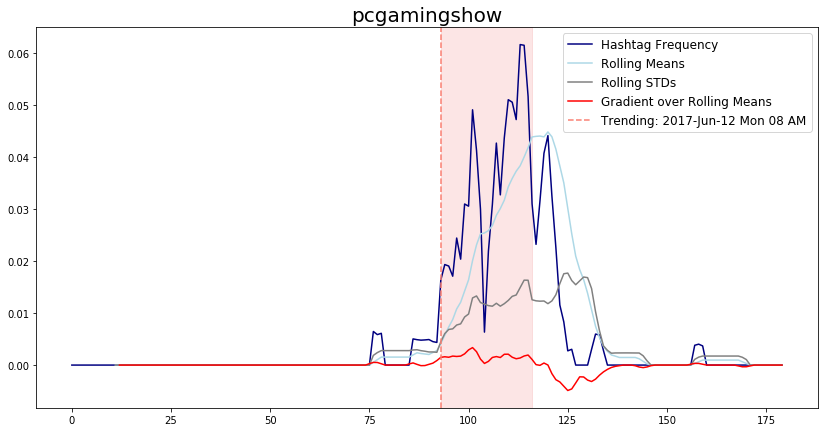

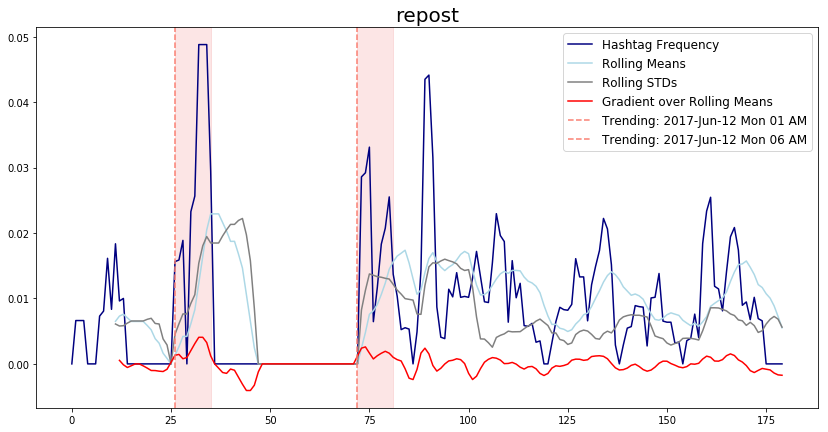

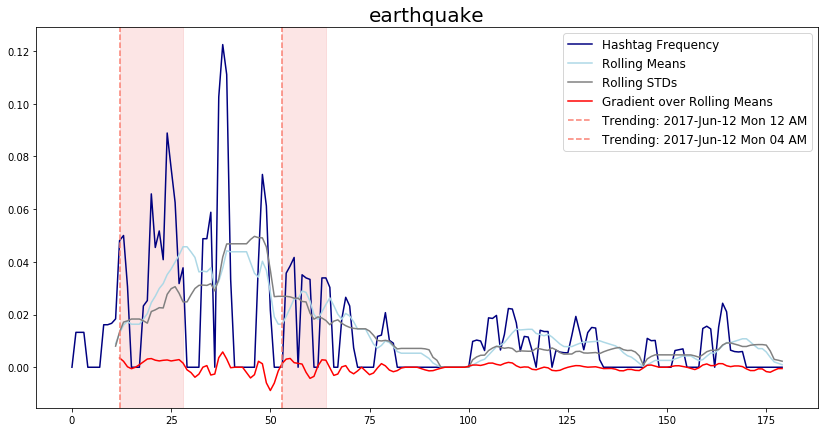

In [78]:
a = [hashtag_trend(i) for i in (hashtag_freq_df['hashtag'].head(10))]

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:33: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:34: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater


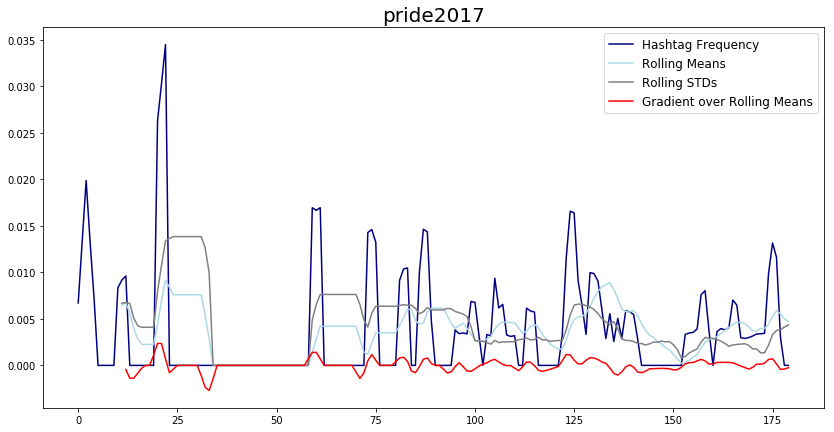

In [79]:
time_df = hashtag_trend('pride2017')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def svd_variance(svd_model, col_index):
    
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(svd_model.components_)+1)]
    components = pd.DataFrame(np.round(svd_model.components_, 4), columns=col_index)
    ratios = svd_model.explained_variance_ratio_.reshape(len(svd_model.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    fig, ax = plt.subplots(figsize = (24,10))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar',legend='False');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)
    ax.legend_.remove()


    # Display the explained variance ratios
    for i, ev in enumerate(svd_model.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

In [ ]:
svd_variance(svd, tfd_word_index)

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


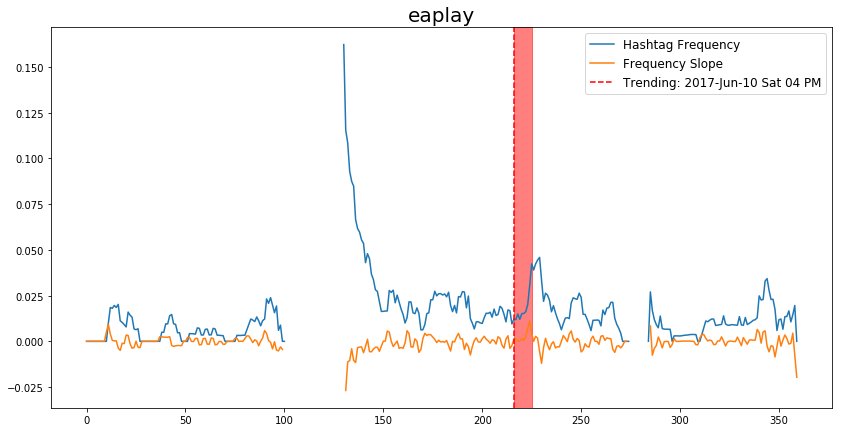

In [162]:
arr, grad, a = hashtag_trend('eaplay')

In [148]:
trend = np.argwhere(grad>0).reshape(1,-1)[0]
trend_group = group_consecutives(trend)
trend_group2 = [i for i in trend_group if (len(i) > 6)]
spike = []
spike.append([[i[0],i[len(i)-1]] for i in trend_group2])
spike = np.array(spike)
spk1 = [i[0] for i in spike[0]]
spk2 = [i[1] for i in spike[0]]
print(spk1)
print(spk2)

[170, 216, 300, 310]
[176, 225, 306, 316]


/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [ ]:
plt.plot(np.gradient(nbafinals_grad))

In [ ]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = .25)
time_gap = timedelta(hours = .1)
windows = int(round(time_delta/time_gap,0))
time_format = '%Y-%h-%d %a %I %p'
from_zone = tz.tzutc()
#to_zone = tz.tzlocal()
to_zone = 'US/Pacific'
def hashtag_trend(hashtag):
    hashtag = hashtag.lower()
    arr = []
    start_time = min(df['created_datetime'])
    for window in range(windows):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) & (df['created_datetime'] > start_time))]
        h = subset.str.contains(hashtag).mean()
        arr.append(h)
        start_time += time_gap
    arr = np.array(arr)  
    
    grad = np.gradient(arr)
    tr = np.argwhere(grad>.01).reshape(1,-1)[0]
    spikes = []
    [spikes.append(i) for i in tr if (i-1) not in tr]
    plt.figure(figsize=(14,7))
    plt.plot(arr, label='Hashtag Frequency')
    plt.plot(grad, label='Frequency Slope')
    
    for i,j in enumerate(spikes):
        spiketime = (min(df['created_datetime']) + time_gap * j) 
        spiketime = spiketime.replace(tzinfo=from_zone)
        spiketime_et = spiketime.astimezone(to_zone)
        spiketime_et = spiketime_et.strftime(time_format)
        
        plt.axvline(j, color = 'r',linestyle='dashed', label = 'Trending: {}'.format(spiketime_et))
    plt.title(hashtag, fontsize=20)    
    plt.legend(fontsize=12)   
    return  arr, grad

In [ ]:
arr, grad = hashtag_trend('hiring')

In [ ]:
svd_variance(svd, tfd_word_index)